In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModel, \
  BitsAndBytesConfig, GPTQConfig
import os

while "notebooks" in os.getcwd():
    os.chdir("..")

from time import time
from pathlib import Path
from tqdm import tqdm
import torch
from langdetect import detect
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from huggingface_hub import notebook_login
from datasets import load_dataset
import math
from typing import List, Optional, Tuple, Union
from torch import nn
from tqdm import tqdm
from IPython.display import clear_output
import warnings
from bert_score import BERTScorer
warnings.filterwarnings("ignore")
from copy import deepcopy
from openai import OpenAI
from babilong.babilong.prompts import DEFAULT_PROMPTS, DEFAULT_TEMPLATE, get_formatted_input
from babilong.babilong.babilong_utils import compare_answers

from src.utils import rotate_half, apply_rotary_pos_emb, repeat_kv, \
    get_context_length, get_generated_text, FileReader, is_text_in_language, rolling_mean

import json

from src.attention_saver import Mistral7BAttentionSaver
from src.influence import Influence

tqdm.pandas()

## Importing models and dataset

In [18]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.1",
    cache_dir = "/Data"    
)


base_model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.1",
    quantization_config = quantization_config,
    device_map="auto",
    attn_implementation="eager",
    cache_dir = "/Data"
)


model_name = base_model.config._name_or_path.split("/")[1]

model = Mistral7BAttentionSaver(
    base_model,
    tokenizer,
    delta_attention=0,
    should_save_params= False
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
df = load_dataset("fireworks-ai/function-calling-eval-dataset-v0", cache_dir = "/Data")\
    ['single_turn']\
    .to_pandas()

Repo card metadata block was not found. Setting CardData to empty.


Generating multi_turn split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating single_turn split:   0%|          | 0/112 [00:00<?, ? examples/s]

In [19]:
context_length = df['prompt'].apply(lambda x: get_context_length(x[0]['content'], tokenizer))

0      3135
1      3173
2      3157
3      3144
4      3152
       ... 
107    3174
108    3147
109    3140
110    3148
111    3165
Name: prompt, Length: 112, dtype: int64

In [5]:
df['instruction'] = df['prompt'].apply(lambda x: x[0]['content'])
df['text'] = df['prompt'].apply(lambda x : x[1]['content'])

In [39]:

df['json_schema'] = df['instruction'][0]\
    .split("<schema>")[1]\
    .split("</schema>")[0]


df['json_context_length'] = df['completion'].progress_apply(get_context_length, tokenizer = tokenizer)

df.head()

,prompt,completion,schema,instruction,text,json_schema,context_length,json_context_length
0,[{'content': 'You are a helpful assistant that...,"{""ssid"": ""OfficeNetSecure"", ""securityProtocol""...","{""title"": ""WirelessAccessPoint"", ""type"": ""obje...",You are a helpful assistant that answers in JS...,I'm currently configuring a wireless access po...,"\n{'title': 'WirelessAccessPoint', 'type': 'ob...",248,44
1,[{'content': 'You are a helpful assistant that...,"{""/"": {""device"": ""/dev/sda1"", ""mount_point"": ""...","{""$id"": ""https://example.com/fstab"", ""$schema""...",You are a helpful assistant that answers in JS...,I need to create a JSON representation of the ...,"\n{'title': 'WirelessAccessPoint', 'type': 'ob...",434,195
2,[{'content': 'You are a helpful assistant that...,"{""campaignID"": ""CAMP123456"", ""productID"": ""PRO...","{""title"": ""PromotionalCampaign"", ""type"": ""obje...",You are a helpful assistant that answers in JS...,I'm organizing a promotional campaign for our ...,"\n{'title': 'WirelessAccessPoint', 'type': 'ob...",300,84
3,[{'content': 'You are a helpful assistant that...,"{""reservationID"": ""AH-158394"", ""guestName"": ""A...","{""title"": ""RestaurantReservation"", ""type"": ""ob...",You are a helpful assistant that answers in JS...,I'd like to make a reservation at The Gourmet ...,"\n{'title': 'WirelessAccessPoint', 'type': 'ob...",285,81
4,[{'content': 'You are a helpful assistant that...,"{""HomeImprovement"": {""room_interest"": ""living ...","{""type"": ""object"", ""properties"": {""HomeImprove...",You are a helpful assistant that answers in JS...,I'm looking to spruce up my living room within...,"\n{'title': 'WirelessAccessPoint', 'type': 'ob...",267,123


In [40]:
TEMPLATE = "You are a helpful assistant that answers in JSON. Here's the json schema you must adhere to:\n\n<schema>\n{schema}\n</schema>\n\n{noise}\n\n{content}\n\nDo not output anything else than the JSON."
print(TEMPLATE)

You are a helpful assistant that answers in JSON. Here's the json schema you must adhere to:

<schema>
{schema}
</schema>

{noise}

{content}

Do not output anything else than the JSON.


In [41]:
tqdm.pandas()
noise_df = load_dataset(
    "stas/openwebtext-10k", cache_dir="/Data"
)['train'].to_pandas()

noise_df['context_length'] = noise_df['text']\
    .progress_apply(get_context_length, tokenizer = tokenizer)

100%|██████████| 10000/10000 [00:09<00:00, 1044.55it/s]


In [51]:
noises = ['']
for n in range(7):
    noise = noise_df.query(f"context_length >= 500*{n} & context_length < 500*{n+1}")\
        .sample(1)\
        .text\
        .item()
    
    noises.append(noise)

In [52]:
all_df = []

for noise in noises:
    this_df = deepcopy(df)
    this_df['prompt'] = this_df.apply(
        lambda row: TEMPLATE.format(
            schema = row['json_schema'],
            noise = noise,
            content = row['text']
        ),
        axis = 1
    )

    all_df.append(this_df)

In [55]:
augmented_df = pd.concat(all_df)\
    .reset_index(drop = True)


augmented_df['context_length'] = augmented_df['prompt']\
    .progress_apply(get_context_length, tokenizer = tokenizer)

  0%|          | 0/800 [00:00<?, ?it/s]

100%|██████████| 800/800 [00:02<00:00, 327.99it/s] 


100%|██████████| 100/100 [00:00<00:00, 5229.48it/s]


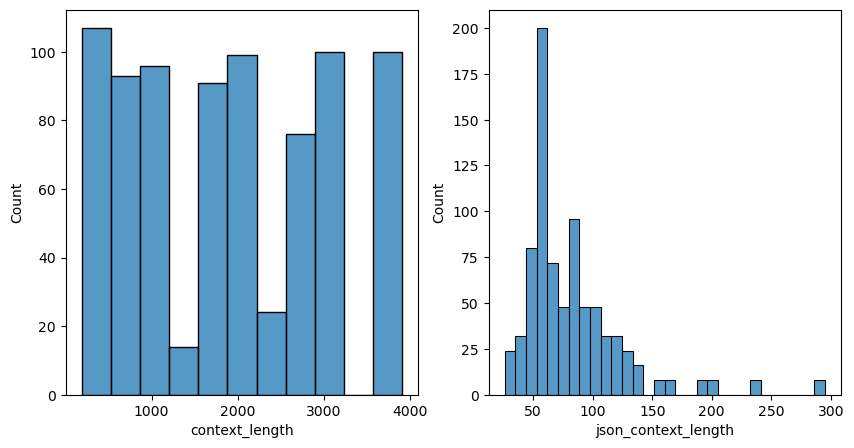

In [59]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize= (10,5))

sns.histplot(augmented_df['context_length'], ax = ax1)
sns.histplot(augmented_df['json_context_length'], ax = ax2)

plt.show()

In [62]:
text

array([{'content': "You are a helpful assistant that answers in JSON. Here's the json schema you must adhere to:\n<schema>\n{'title': 'WirelessAccessPoint', 'type': 'object', 'properties': {'ssid': {'title': 'SSID', 'type': 'string'}, 'securityProtocol': {'title': 'SecurityProtocol', 'type': 'string'}, 'bandwidth': {'title': 'Bandwidth', 'type': 'string'}}, 'required': ['ssid', 'securityProtocol', 'bandwidth']}\n</schema>\n", 'role': 'system'},
       {'content': "I'm currently configuring a wireless access point for our office network and I need to generate a JSON object that accurately represents its settings. The access point's SSID should be 'OfficeNetSecure', it uses WPA2-Enterprise as its security protocol, and it's capable of a bandwidth of up to 1300 Mbps on the 5 GHz band. This JSON object will be used to document our network configurations and to automate the setup process for additional access points in the future. Please provide a JSON object that includes these details.", 

In [64]:
row

prompt                 You are a helpful assistant that answers in JS...
completion             {"statementID": "GDB-4512", "customerID": "CUS...
schema                 {"title": "AccountStatement", "type": "object"...
instruction            You are a helpful assistant that answers in JS...
text                   I need to create a digital record of my recent...
json_schema            \n{'title': 'WirelessAccessPoint', 'type': 'ob...
context_length                                                      3844
json_context_length                                                  295
Name: 732, dtype: object

In [84]:
checkpoint_path = "data/study-04-json/01/checkpoints/delta={delta}.parquet"
base_path = "data/study-04-json/01/delta={delta}.parquet"

In [85]:
row

prompt                 You are a helpful assistant that answers in JS...
completion             {"current_location": "Boulder, Colorado", "pre...
schema                 {"WeatherUpdates": {"type": "object", "propert...
instruction            You are a helpful assistant that answers in JS...
text                   I'm planning to go hiking this weekend and I n...
json_schema            \n{'title': 'WirelessAccessPoint', 'type': 'ob...
context_length                                                      3813
json_context_length                                                  197
Name: 772, dtype: object

In [86]:
DELTA_ATTENTION = 0

In [92]:
# endline_token = 13
# tab_token = 12
# double_backspace_token = 259
# triple_backspace_token = 2287
# backspace_token = 28705
# quotation_mark_token = 345
# left_brace_token = 371

decoded = None
generated_text = {}

for i, (idx, row) in enumerate(augmented_df.sort_values("context_length", ascending= False).iterrows()):
    
    text = row['prompt']
    message = [{"role": "user", "content": text}]
    schema = row['json_schema'] 
    "<schema>\n" "\n</schema>"
    template = tokenizer.apply_chat_template(message, tokenize=False)
    
    splits = template.split("<schema>\n" + schema +"\n</schema>")
    initial_prompt = splits[0]
    context = splits[1]

    assert (hash(initial_prompt+"<schema>\n"+schema+"\n</schema>"+context) == hash(template)), "Error in spliting strings. Initial and final string does not match"

    initial_tokens = tokenizer.encode(initial_prompt, return_tensors='pt')
    open_tag_tokens = tokenizer.encode("<schema>\n", return_tensors='pt')
    schema_tokens = tokenizer.encode(schema, return_tensors='pt')
    close_tag_tokens = tokenizer.encode("\n</schema>", return_tensors='pt')
    context_tokens = tokenizer.encode(context, return_tensors='pt')

    start_idx = initial_tokens.size(1) + open_tag_tokens.size(1) - 1
    end_idx = start_idx + schema_tokens.size(1) - 1

    model.set_reference_tokens(start_idx, end_idx)
    
    tokens = torch.concat([
        initial_tokens.squeeze(), 
        open_tag_tokens.squeeze()[1:],
        schema_tokens.squeeze()[1:],
        close_tag_tokens.squeeze()[1:],
        context_tokens.squeeze()[1:]
    ]).unsqueeze(0)

    q = tokenizer.decode(tokens.squeeze()[start_idx: end_idx])

    assert schema in q, "Error in tokenization. Not giving attention to correct tokens"

    tokens2 = tokenizer(template, return_tensors='pt')

    assert (abs(tokens.shape[1] - tokens2['input_ids'].shape[1]) <=5 ), "Error in tokenization. Tokens do not match"

    clear_output()

    if decoded is not None:
        json_obj = decoded.split("[/INST]")[1]\
            .replace("\n", '')\
            .replace('</s>', '')\
            .replace('\r', '')\
            .replace('          ', '')\
            .replace("\\", '')
        
        try:
            json_obj   = json.loads(json_obj)
            target = json.loads(target)
            
            is_equal = json_obj == target

        except:
            is_equal = 'error in json loading'

        print(
            f'''
            text index = {idx},
            context length = {row['context_length']},
            last generated text = 
{decoded.split('[/INST]')[1]}
            correct = {is_equal}
            '''
        )

    with torch.no_grad():
        generated_ids = model.generate(
            tokens, 
            max_new_tokens = 1_000, 
            # suppress_tokens = [endline_token, tab_token, double_backspace_token, backspace_token, triple_backspace_token],
            # forced_decoder_ids = [[0, left_brace_token]],
            do_sample = False,
        )

    decoded = (tokenizer.batch_decode(generated_ids)[0])
    target = row['completion']
    generated_text[idx] = decoded

    if i % 100  == 0:
        checkpoint_file = checkpoint_path.format(
            delta = DELTA_ATTENTION
        )
        checkpoint_file = Path(checkpoint_file)
        checkpoint_file.parent.mkdir(parents=True, exist_ok=True)
        augmented_df['generated_text'] = pd.Series(generated_text)
        augmented_df.to_parquet(checkpoint_file)

outfile = base_path.format(
    delta = DELTA_ATTENTION
)

outfile.parent.mkidr(parents = True, exist_ok = True)
augmented_df['generated_text'] = pd.Series(generated_text)
augmented_df.to_parquet(outfile)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



            text index = 780,
            context length = 3817,
            last generated text = 
 {
"chemical\_id": "GC2022-7705",
"name": "Lignin-derived polymeric compound",
"type": "Polymer",
"applications": [
"Energy storage",
"Targeted drug delivery",
"Efficient adsorption",
"Catalysis",
"Functional packaging",
"Slow-release fertilizers"
]
}</s>
            correct = False
            


KeyboardInterrupt: 

: 

In [82]:
augmented_df['generated_text'] = pd.Series(generated_text)

In [83]:
augmented_df

,prompt,completion,schema,instruction,text,json_schema,context_length,json_context_length,generated_text
0,You are a helpful assistant that answers in JS...,"{""ssid"": ""OfficeNetSecure"", ""securityProtocol""...","{""title"": ""WirelessAccessPoint"", ""type"": ""obje...",You are a helpful assistant that answers in JS...,I'm currently configuring a wireless access po...,"\n{'title': 'WirelessAccessPoint', 'type': 'ob...",265,44,NaN
1,You are a helpful assistant that answers in JS...,"{""/"": {""device"": ""/dev/sda1"", ""mount_point"": ""...","{""$id"": ""https://example.com/fstab"", ""$schema""...",You are a helpful assistant that answers in JS...,I need to create a JSON representation of the ...,"\n{'title': 'WirelessAccessPoint', 'type': 'ob...",220,195,NaN
2,You are a helpful assistant that answers in JS...,"{""campaignID"": ""CAMP123456"", ""productID"": ""PRO...","{""title"": ""PromotionalCampaign"", ""type"": ""obje...",You are a helpful assistant that answers in JS...,I'm organizing a promotional campaign for our ...,"\n{'title': 'WirelessAccessPoint', 'type': 'ob...",262,84,NaN
3,You are a helpful assistant that answers in JS...,"{""reservationID"": ""AH-158394"", ""guestName"": ""A...","{""title"": ""RestaurantReservation"", ""type"": ""ob...",You are a helpful assistant that answers in JS...,I'd like to make a reservation at The Gourmet ...,"\n{'title': 'WirelessAccessPoint', 'type': 'ob...",257,81,NaN
4,You are a helpful assistant that answers in JS...,"{""HomeImprovement"": {""room_interest"": ""living ...","{""type"": ""object"", ""properties"": {""HomeImprove...",You are a helpful assistant that answers in JS...,I'm looking to spruce up my living room within...,"\n{'title': 'WirelessAccessPoint', 'type': 'ob...",266,123,NaN
...,...,...,...,...,...,...,...,...,...
795,You are a helpful assistant that answers in JS...,"{""portName"": ""Harbor Bay Port"", ""date"": ""2023-...","{""title"": ""DockingTimeQuery"", ""type"": ""object""...",You are a helpful assistant that answers in JS...,I need to schedule a shipment arrival at a mar...,"\n{'title': 'WirelessAccessPoint', 'type': 'ob...",3711,81,NaN
796,You are a helpful assistant that answers in JS...,"{""productName"": ""Organic Red Apples"", ""SKU"": ""...","{""properties"": {""productName"": {""title"": ""Prod...",You are a helpful assistant that answers in JS...,I am currently managing the inventory for our ...,"\n{'title': 'WirelessAccessPoint', 'type': 'ob...",3717,54,NaN
797,You are a helpful assistant that answers in JS...,"{""diesel"": {""fuelType"": ""Diesel"", ""quantityInS...","{""FuelInventoryReport"": {""title"": ""FuelInvento...",You are a helpful assistant that answers in JS...,I am currently managing the inventory for our ...,"\n{'title': 'WirelessAccessPoint', 'type': 'ob...",3816,127,<s><s> [INST] You are a helpful assistant that...
798,You are a helpful assistant that answers in JS...,"{""shipmentID"": ""SH12345"", ""componentID"": ""COMP...","{""title"": ""ShipmentStatusTracker"", ""type"": ""ob...",You are a helpful assistant that answers in JS...,"Hello, I am currently managing logistics for o...","\n{'title': 'WirelessAccessPoint', 'type': 'ob...",3800,58,NaN


In [80]:
target

'{"diesel": {"fuelType": "Diesel", "quantityInStock": 5000, "reorderLevel": 1500}, "gasoline": {"fuelType": "Gasoline", "quantityInStock": 7500, "reorderLevel": 2000}, "aviationFuel": {"fuelType": "Aviation Fuel", "quantityInStock": 2500, "reorderLevel": 1000}}'

In [77]:
json_obj

' {"distributor\\_id": "DIST12345X","company\\_name": "Gadgets and Widgets Co.","phone\\_number": "+1-555-0199","email\\_address": "contact@gadgets-widgets.com","physical\\_address": "1234 Innovation Way, Tech City, 98765","categories": ["Electronics", "Home Appliances", "Office Supplies"]}'

In [43]:
pd.Series(generated_text).to_pickle("data/study-04-json/delta=0.pkl")

In [49]:
df['generated_text'] = pd.Series(generated_text)\
    .apply(lambda x: x.split('[/INST]')[1])\
    .apply(
        lambda x:   x.replace("\n", '')\
                     .replace('</s>', '')\
                     .replace('\r', '')\
                     .replace('          ', '')
    )

## Scoring generation

In [52]:
def get_json(x):
    try :
        return json.loads(x)
    
    except : 
        return 0

df['json'] = df['generated_text'].apply(get_json)

In [59]:
df['completion'] = df['completion'].apply(json.loads)

In [71]:
def score_json(row):
    target_json = row['completion']
    generated_json = row['json']
    
    if generated_json == 0:
        return 0
    

    
    n_keys = len(target_json)
    acc = 0

    for key in target_json.keys():
        if not key in generated_json:
            continue

        if generated_json[key] == target_json[key]:
            acc += 1

    return acc/max(n_keys, len(generated_json))

In [75]:
df.apply(score_json, axis = 1)\
    .mean()

0.7968333333333334

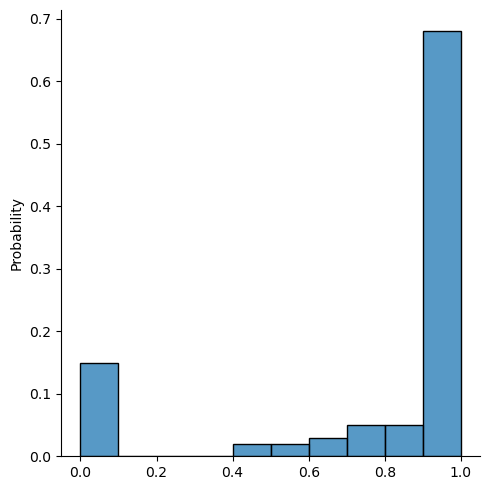

In [72]:
sns.displot(df.apply(score_json, axis = 1), stat = 'probability')

In [66]:
len(df['completion'].iloc[0])

3